# **CAL FIRE Trend Forecasting and Analysis**


## Description and deliverables

California experiences some of the most severe and frequent wildfires in the United States. With the current tides of climate change, population growth, and developing land uses, understanding patterns of wildfire activity is becoming an increasingly important consideration for the residents and government of California. To better understand these patterns and support proactive decision-making, this project focuses on trend forecasting and analysis using historical incident data provided by CAL Fire.

The project integrates data analytics and machine learning techniques to explore wildfire behavior, identify risk factors, and generate predictive insights. The workflow begins with acquiring raw incident data directly from CAL FIRE's public databases, followed by data cleaning, transformation, and storage in a relation database for efficient querying. Exploratory data analysis (EDA) highlights temporal, geographic, and environmental patterns to allow for further insights. Additionally, machine learning techniques are applied to the data in order to uncover even more trends that display wildfire activity analytics.

The end product is a data pipeline and interactive dashboard that automatically updates with new incident data, delivering actionable insights to fire management agencies, policymakers, and researchers. This allows stakeholders to track wildfire activity in realtime, monitor trends, and simulate future scenarios to improve preparedness, resource allocation, and public safety.

This notebook serves as the back-bone of this project's workflow. While all dashboards, visualizations, and metrics can be viewed by running the core Python file, this notebook keeps track of the ins-and-outs of the decision-making behind the analysis.

## Exploratory Data Analysis (EDA)

In the dataset provided by [CAL FIRE](https://www.fire.ca.gov/), detailed records of wildfire incidents across California are made publicly available. The data can be accessed directly through CAL FIRE's open data portal [here](https://incidents.fire.ca.gov/imapdata/mapdataall.csv), which is updated regularly to reflect both active and historical incidents.

This dataset includes a number of attributes, but the ones we will be focusing on are:
Variable|Description |
-----|-----|
incident_name | The official name or title of the wildfire incident.|
incident_date_created | The date and time when the incident was first reported or created in the system.|
incident_administrative_unit | The CAL FIRE administrative unit or agency responsible for managing the incident.|
incident_county | The county in California where the incident occurred.|
incident_location | A descriptive location of the incident, such as city, town, or nearby landmark.|
incident_acres_burned | The total number of acres burned during the incident.|
incident_containment | The percentage of the fire that has been contained at the time of reporting.|
incident_cooperating_agencies | Other local, state, or federal agencies assisting with the incident response.|
incident_longitude | The longitude coordinate of the incident’s location.|
incident_latitude | The latitude coordinate of the incident’s location.|
incident_id | A unique identifier assigned to each incident (string or numeric).|
incident_url | A direct link to the CAL FIRE incident webpage for more details.|
incident_date_extinguished | The date and time when the incident was declared fully extinguished.|
is_active | Status flag indicating whether the incident is still active or has been contained/closed. |
calfire_incident | Boolean value indicating whether the incident was directly managed by CAL FIRE. |

In the dataset provided by the Government of California's API, detailed records of monthly precipitation levels for each County across California are made publicly available. The link to the API can be found [here](https://lab.data.ca.gov/dataset/annual-precipitation-data-for-northern-california-1944-current/c66bcc83-d895-48cf-a639-a53974899b88).

This dataset includes a number of attributes, but the ones we will be focusing on are:
Variable|Description |
-----|-----|
incident_name | The official name or title of the wildfire incident.|
precip_date | The datetime in which the record comes from. |
precip_inches | The total inches of precipitation in each county, in each month. |
precip_month | Number equating to the month of the year. |
county | The county from which the record is referring to.

# Step 1. Download CAL FIRE and Precipitation Data

The first step in our analysis is to construct a database to store the most up-to-date 'incidents' data. For this task, we will be initializing a Google Cloud PostgreSQL instance and creating/uploading/verifying our database automatically when the username and password are entered. The included Python script in this repository, "download_data.py", will complete this when run in the next code block if execute is set to "True" (Only enable if database is online). After, all we have to do is query the data and begin EDA!

In [56]:
from downloader import PrecipDownloader, WildfireDownloader
import pandas as pd
import os


Update = False
if os.path.exists('county_precipitation_data.csv') and Update == False:
    precip_df = pd.read_csv('county_precipitation_data.csv')
else:
    precip_df = PrecipDownloader().precip_download()
    precip_df.to_csv('county_precipitation_data.csv')
if os.path.exists('cal_fire_incidents.csv') and Update == False:
    wildfire_df = pd.read_csv('cal_fire_incidents.csv')
else:
    wildfire_df = WildfireDownloader().calfire_download()
    wildfire_df.to_csv('cal_fire_incidents.csv')


# Step 2. Data Exploration

## Part A. CAL FIRE Data

Now that we have saved the CAL FIRE data in a dataframe, 'wildfire_df', it is important to develop a fundamental understanding of our data. While the basic data cleaning occurs during the initialization of the database, we can look deeper into the data to discover further trends. To do so, we will make a copy of the database, 'df'.

### Gather basic information about the data

In [137]:
df = wildfire_df.copy()
df['incident_date_created'] = pd.to_datetime(df['incident_date_created'])
df['incident_date_extinguished'] = pd.to_datetime(df['incident_date_extinguished'])
df = df[df['incident_date_created'].dt.year >= 2015]
df['incident_county'] = df['incident_county'].str.split(",").str[0].str.strip()
df = df[~df['incident_county'].isin(['State of Nevada','State of Oregon','Mexico'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3082 entries, 0 to 3306
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   Unnamed: 0                     3082 non-null   int64              
 1   incident_name                  3082 non-null   object             
 2   incident_date_created          3082 non-null   datetime64[ns, UTC]
 3   incident_administrative_unit   3018 non-null   object             
 4   incident_county                3074 non-null   object             
 5   incident_location              3082 non-null   object             
 6   incident_acres_burned          3029 non-null   float64            
 7   incident_containment           3017 non-null   float64            
 8   incident_cooperating_agencies  1469 non-null   object             
 9   incident_longitude             3082 non-null   float64            
 10  incident_latitude            

In [58]:
df.describe()

,Unnamed: 0,incident_acres_burned,incident_containment,incident_longitude,incident_latitude
count,3082.000000,3.029000e+03,3017.000000,3.082000e+03,3082.000000
mean,1763.175211,3.796411e+03,99.573749,-3.866917e+05,38.772244
std,892.500057,3.345576e+04,5.787857,2.146083e+07,98.305352
min,0.000000,0.000000e+00,0.000000,-1.191415e+09,-120.258000
25%,989.250000,2.500000e+01,100.000000,-1.216217e+02,34.739778
50%,1765.500000,6.700000e+01,100.000000,-1.204466e+02,37.083285
75%,2535.750000,2.800000e+02,100.000000,-1.185748e+02,39.030451
max,3306.000000,1.032648e+06,100.000000,1.189082e+02,5487.000000


In [59]:
df.isna().sum()

Unnamed: 0                          0
incident_name                       0
incident_date_created               0
incident_administrative_unit       64
incident_county                     8
incident_location                   0
incident_acres_burned              53
incident_containment               65
incident_cooperating_agencies    1613
incident_longitude                  0
incident_latitude                   0
incident_id                         0
incident_url                        0
incident_date_extinguished        766
is_active                           0
calfire_incident                    0
dtype: int64

### Missing Values

The above function tells us more about what data is and is not available. It seems as though there are some NaN values for some attributes. Some of these null values will have no impact on the analysis, but some will. We can take care of those. It is important to remember, as new data is released, more entries will added which may contain NaN values. We will handle these differently for each variable.

* 'incident_acres_burned' has a few NaN value at the time of analysis, which is hard to impute so we can drop that row and any future entries with NaN.
* 'incident_county' is also NA, but in minimum quantities, so we will drop this as well.
* 'incident_administrative_unit' has 63, but the attribute itself is not very impactful on our research.
* 'incident_cooperating_agencies' is similar to admin unit, it is not super important.
* 'incident_containment' can be solved by checking if the fire is active or not.
* 'incident_date_extinguished' is tricky, we will have to solve this NaN value issue to complete our analysis.

In [60]:
df = df.dropna(subset = ['incident_acres_burned', 'incident_county', 'incident_containment'])
df.isna().sum()

Unnamed: 0                          0
incident_name                       0
incident_date_created               0
incident_administrative_unit       59
incident_county                     0
incident_location                   0
incident_acres_burned               0
incident_containment                0
incident_cooperating_agencies    1563
incident_longitude                  0
incident_latitude                   0
incident_id                         0
incident_url                        0
incident_date_extinguished        723
is_active                           0
calfire_incident                    0
dtype: int64

Now, to deal with 'incident_date_extinguished', it will be more fruitful to analyze the duration of each fire rather than this attribute. As the histogram shows below, there is a left skew of the data. This means that a majority of the wildfires only last a couple of days. Despite this, looking past the 20 day mark, most fires follow a normally distributed duration. We can use these two states to determine the likely missing values of 'duration' based on how large the fire is.

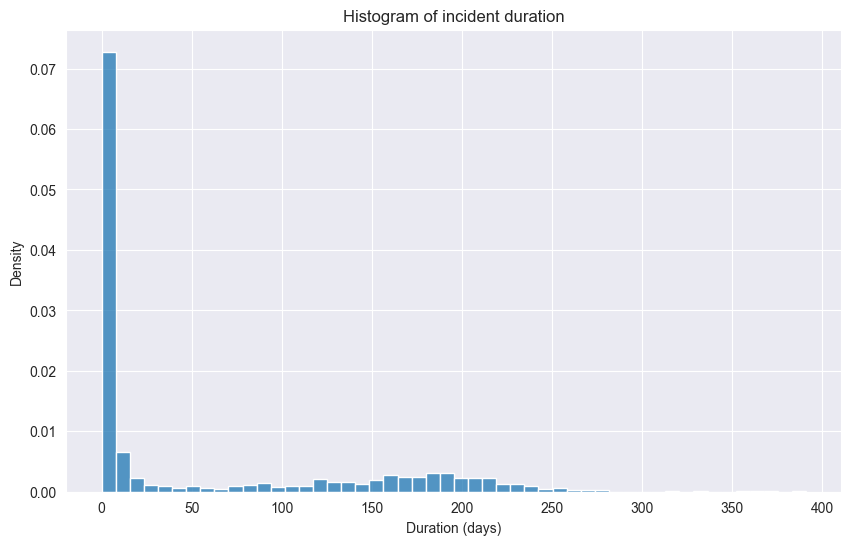

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
df['duration'] = df['incident_date_extinguished'] - df['incident_date_created']
df.loc[df['duration'] < pd.Timedelta(0), 'duration'] = pd.NaT
df['duration_days'] = df['duration'].dt.days

plt.figure(figsize=(10,6))
sns.histplot(df['duration_days'], bins = 50, kde = False, stat = 'density')
plt.title('Histogram of incident duration')
plt.xlabel('Duration (days)')
plt.ylabel('Density')
plt.show()


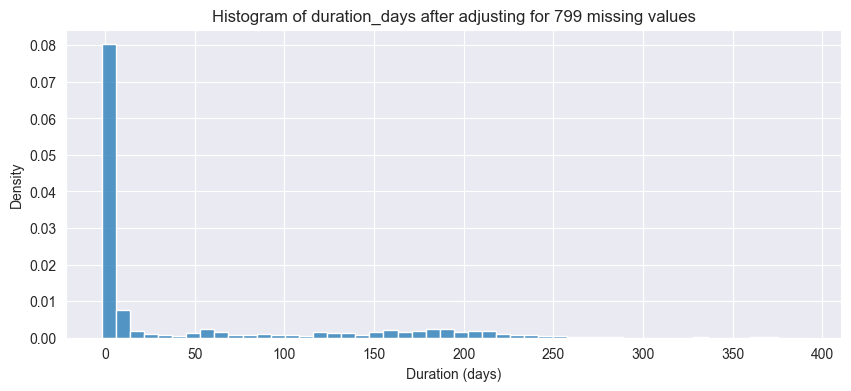

In [78]:
import numpy as np
mean_duration = df['duration_days'].mean()
duration_na_count = df['duration'].isna().sum()


df.loc[df['duration_days'].isna() & (df['incident_acres_burned'] >= 1000), 'duration_days'] = \
    np.random.normal(loc=mean_duration, scale=5, size=(df["duration_days"].isna() & (df["incident_acres_burned"] >= 1000)).sum()).round()
df.loc[df['duration_days'].isna() & (df['incident_acres_burned'] < 1000), 'duration_days'] = \
    np.random.normal(loc=1, scale=1, size=(df["duration_days"].isna() & (df["incident_acres_burned"] < 1000)).sum()).round()

plt.figure(figsize=(10,4))
sns.histplot(df['duration_days'], bins = 50, kde = False, stat = 'density')
plt.title(f'Histogram of duration_days after adjusting for {duration_na_count} missing values')
plt.xlabel('Duration (days)')
plt.ylabel('Density')
plt.show()

And now we can correct date_extinguished with these values.

In [80]:
df['incident_date_extinguished'] = df['incident_date_created'] + pd.to_timedelta(df['duration_days'], unit='days')
df.isnull().sum()

Unnamed: 0                          0
incident_name                       0
incident_date_created               0
incident_administrative_unit       59
incident_county                     0
incident_location                   0
incident_acres_burned               0
incident_containment                0
incident_cooperating_agencies    1563
incident_longitude                  0
incident_latitude                   0
incident_id                         0
incident_url                        0
incident_date_extinguished          0
is_active                           0
calfire_incident                    0
duration                          799
duration_days                       0
dtype: int64

Now that we have completed our data manipulation when it comes to NaN values, we can look at any outliers our data may possess.

### Handling Outliers
With a database such as this that covers such a broad range of attributes (think about how many varying the longitude value could be across the entire state of California), we need to be creative in order to assure that all values are acting accordingly.

The first notion that comes to mind, as just stated, is incident_longitude and incident_latitude. These two values, while quite varying, need to fit into the state of California in order to qualify for our assessment. When putting the data into a geospatial map, it is apparent that some of these latitude, longitude combinations are out of range or null. We can fix this by finding the average of 'incident_longitude' and 'incident_latitude' across the dataset when 'incident_county' is the same as the outlier's. With how many data entries there are in this database, it's unlikely the outliers will have a significant effect on the data when their manipulated like this.

In [81]:
if 'incident_latitude_clean' not in df.columns:
    df['incident_latitude_clean'] = df['incident_latitude']
if 'incident_longitude_clean' not in df.columns:
    df['incident_longitude_clean'] = df['incident_longitude']

def is_outlier(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return True
    return not (32.5 <= lat <= 42 and -124.5 <= lon <= -114)

df['incident_latitude_clean'] = df.apply(
    lambda row: np.nan if is_outlier(row['incident_latitude'], row['incident_longitude'])
    else row['incident_latitude'],
    axis=1
)

df['incident_longitude_clean'] = df.apply(
    lambda row: np.nan if is_outlier(row['incident_latitude'], row['incident_longitude'])
    else row['incident_longitude'],
    axis=1
)

county_means = df.groupby('incident_county')[['incident_longitude_clean', 'incident_latitude_clean']].mean()
df = df.join(county_means, on='incident_county', rsuffix='_county_avg')

df['incident_latitude_clean'] = df['incident_latitude_clean'].fillna(df['incident_latitude_clean_county_avg'])
df['incident_longitude_clean'] = df['incident_longitude_clean'].fillna(df['incident_longitude_clean_county_avg'])
df = df.drop(['incident_latitude_clean_county_avg', 'incident_longitude_clean_county_avg'], axis=1)

print(df[['incident_latitude_clean', 'incident_longitude_clean']].describe())

       incident_latitude_clean  incident_longitude_clean
count              3004.000000               3004.000000
mean                 37.036065               -120.103900
std                   2.511929                  2.000506
min                  32.557566               -124.362017
25%                  34.723625               -121.638614
50%                  37.078569               -120.456931
75%                  39.018085               -118.571288
max                  41.999341               -114.276308


Now we can look towards other important variables, so next lets handle the 'duration' variable that we created earlier. If there are outliers, we will follow the standard data analytics practice of setting the upper limit equal the interquartile range multiplied by 1.6 which is then added to the value at 75th percentile. This step is important as performing an internet search query for "Longest lasting California Fire" results in the Mendocino Complex Fire, which lasts 161 days, which is shorter than a decent portion of our data. It is understandable and therefore somewhat accurate to allow fire duration to last longer than this value. This is in part because while a fire might still have hot spots, its containment is roughly or near 100%

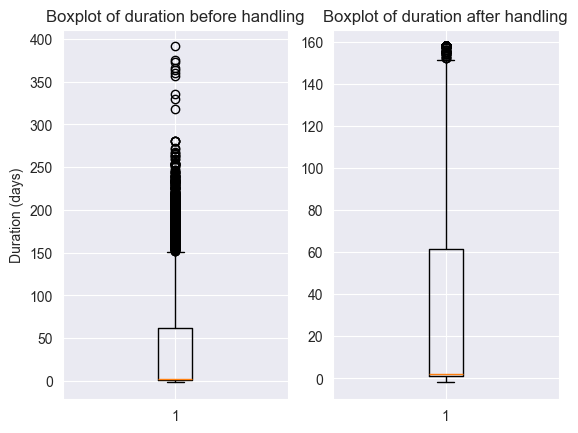

In [82]:
df_subset = df.copy()

percentile25 = df['duration_days'].quantile(0.25)
percentile75 = df['duration_days'].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.6 * iqr
df_subset.loc[df_subset['duration_days'] > upper_limit, 'duration_days'] = upper_limit

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)
ax1.boxplot(x=df['duration_days'])
ax1.set_title('Boxplot of duration before handling')
ax1.set_ylabel('Duration (days)')

ax2.boxplot(x=df_subset['duration_days'])
ax2.set_title('Boxplot of duration after handling')
plt.show()

## Part B. Precipitation Data

Now that we have finished our preliminary data exploration of our CAL FIRE data, we can look into the precipitation data available through California's Governmental Public Database. We will follow similar steps that we did with the first dataframe.

In [83]:
precip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8062 entries, 0 to 8061
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     8062 non-null   int64  
 1   precip_date    8062 non-null   object 
 2   precip_inches  8062 non-null   float64
 3   precip_month   8062 non-null   int64  
 4   precip_year    8062 non-null   int64  
 5   county         8062 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 378.0+ KB


In [84]:
precip_df.describe()

,Unnamed: 0,precip_inches,precip_month,precip_year
count,8062.000000,8062.000000,8062.000000,8062.000000
mean,4030.500000,16.220552,6.374101,2019.302158
std,2327.443268,14.042141,3.437783,3.349544
min,0.000000,0.000000,1.000000,2014.000000
25%,2015.250000,5.640000,3.000000,2016.000000
50%,4030.500000,12.230000,6.000000,2019.000000
75%,6045.750000,23.000000,9.000000,2022.000000
max,8061.000000,101.370000,12.000000,2025.000000


In [85]:
precip_df['county'].value_counts()

county
Alameda            139
Alpine             139
Amador             139
Butte              139
Calaveras          139
Colusa             139
Contra Costa       139
Del Norte          139
El Dorado          139
Fresno             139
Glenn              139
Humboldt           139
Imperial           139
Inyo               139
Kern               139
Kings              139
Lake               139
Lassen             139
Los Angeles        139
Madera             139
Marin              139
Mariposa           139
Mendocino          139
Merced             139
Modoc              139
Mono               139
Monterey           139
Napa               139
Nevada             139
Orange             139
Placer             139
Plumas             139
Riverside          139
Sacramento         139
San Benito         139
San Bernardino     139
San Diego          139
San Francisco      139
San Joaquin        139
San Luis Obispo    139
San Mateo          139
Santa Barbara      139
Santa Clara        139
Sant

In [86]:
precip_df.isna().sum()

Unnamed: 0       0
precip_date      0
precip_inches    0
precip_month     0
precip_year      0
county           0
dtype: int64

### Missing Data

As the above code output shows, the precipitation dataframe does not have any missing data. Because of this, we can quickly move on to look at our data distribution and find any outliers within the data.

<Axes: xlabel='precip_inches'>

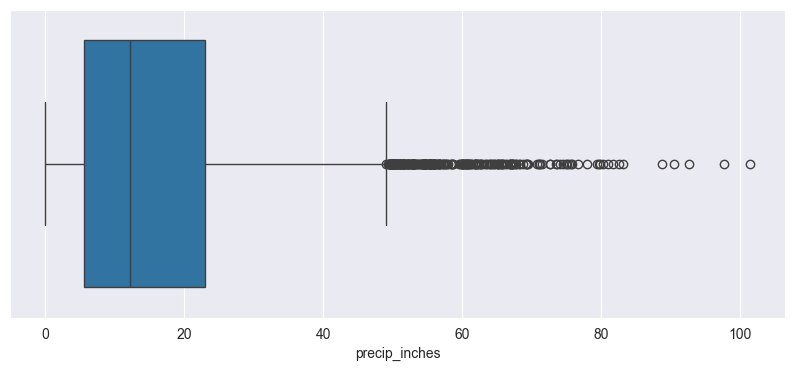

In [87]:
plt.figure(figsize=(10,4))
sns.boxplot(x=precip_df['precip_inches'])

# Step 3. Continued Data Exploration & Feature Engineering
## Part A. CAL FIRE Data
Now that we have cleaned the majority of our data for missing values and outliers, we can look towards techniques to increase the 'usability' of our data. Once such way of performing these tasks is through feature engineering. The first step we can take is pretty simple, extracting date elements out of 'incident_date_created' in order to point out recurring trends. Remember, our CAL FIRE data is still temporarily referred to as 'df_subset'.

In [88]:
df_subset['incident_year'] = df_subset['incident_date_created'].dt.year
df_subset['incident_month'] = df_subset['incident_date_created'].dt.month
df_subset['is_fire_season'] = df_subset['incident_month'].apply(lambda x: 1 if x in [6,7,8,9,10] else 0)
df_subset['incident_season'] = df_subset['incident_month'].apply(
    lambda x: 'Winter' if x in [12,1,2] else 'Spring' if x in [3,4,5] else 'Summer' if x in [6,7,8] else 'Fall')

In [100]:
season_check = df_subset['is_fire_season'].value_counts()
print(f"{(season_check[1] / (season_check[1] + season_check[0]) * 100):.2f}% of fires are in 'fire season'")

82.59% of fires are in 'fire season'


With this, we can check the distribution of fires throughout the year in accordance with the month.

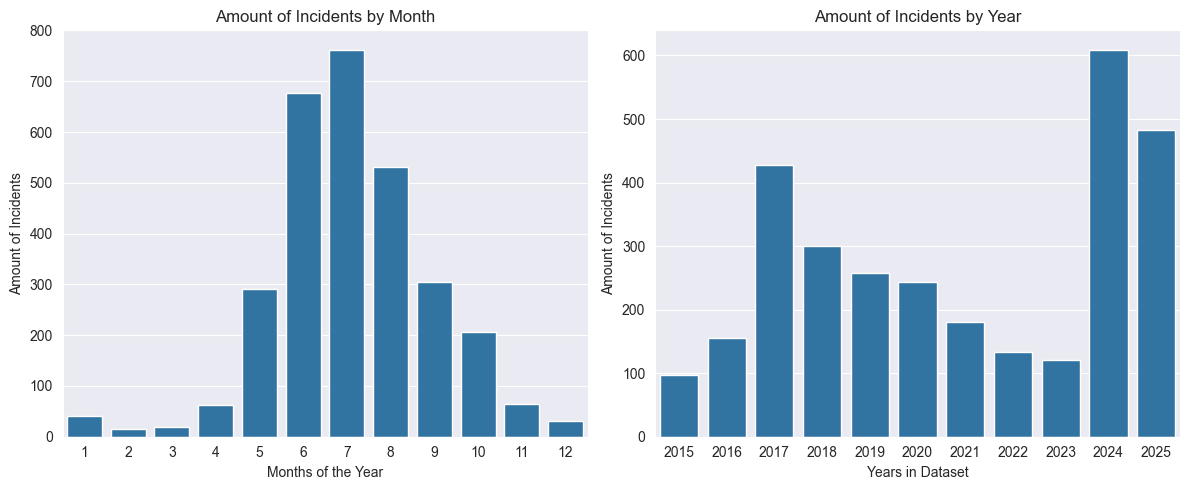

Percentage of Fires in Wildfire Season: 82.59%


In [101]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(df_subset, x = 'incident_year', ax = axes[1])
axes[1].set_title("Amount of Incidents by Year")
axes[1].set_xlabel('Years in Dataset')
axes[1].set_ylabel('Amount of Incidents')
sns.countplot(df_subset, x = 'incident_month', ax = axes[0])
axes[0].set_title("Amount of Incidents by Month")
axes[0].set_xlabel('Months of the Year')
axes[0].set_ylabel('Amount of Incidents')
plt.tight_layout()
plt.show()
season_percentage = (df_subset['is_fire_season'] == 1).sum() / df_subset['is_fire_season'].count() * 100
print(f"Percentage of Fires in Wildfire Season: {season_percentage:.2f}%")

From the graphs featured above, we can see a trend of regularity within the wildfire season. From the left count plot, "Amount of Incidents by Month", shows a distinct pattern of just how many incidents occur during the wildfire season in comparison to the rest of the year. In the northern hemisphere, it is generally considered that the months of May through October are commonly considered the main months of activity. This is proven by the distribution of incidents across the year. At the time of analysis, approximately 82.32% of fires occur during May - October, with July having the highest number of incidents total. As for the count plot on the left, we can see the composition of years that make up our dataset. It is immediately noticeable that there is a skew favoring towards the right side of the data where the years are most recent. This is an interesting pattern that we should look into further. For this reason, the two count graphs below are more specialized, as they demonstrate the same information except strictly limited to fires over 1,000 and 10,000 acres respectively. As apparent, the data tells us a drastically different story: a multi-year pattern appears to exist across the time range. Because our dataset is limited in the amount of information available across history, we may not be able to extract all critical trends that exist within wildfire seasonality, but we will look further into this trend during the Time Series Forecasting section of our analysis.

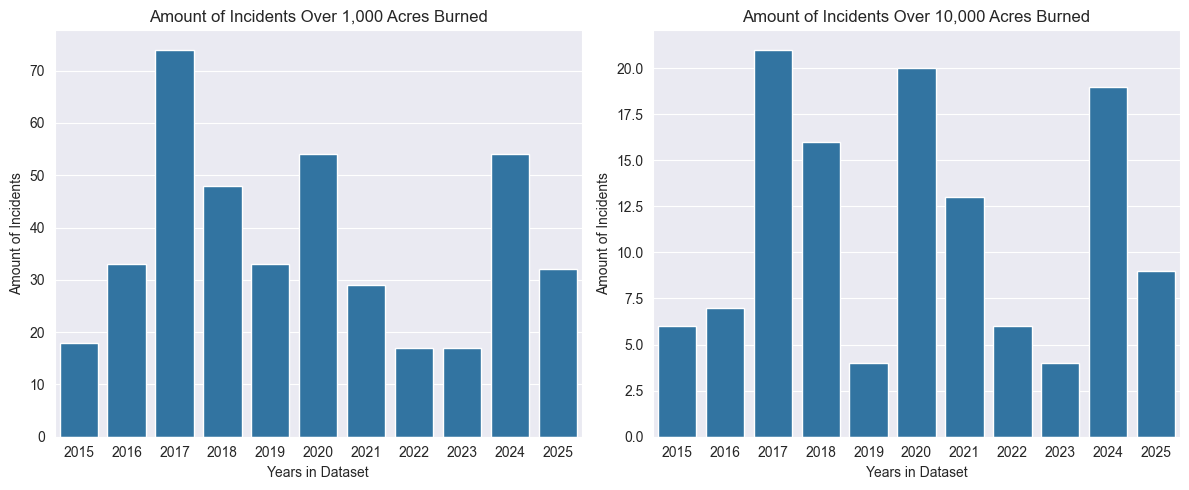

In [102]:
df_1e4_fires = df_subset[df_subset['incident_acres_burned'] > 10000]
df_1e3_fires = df_subset[df_subset['incident_acres_burned'] > 1000]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(df_1e3_fires, x = 'incident_year', ax = axes[0])
axes[0].set_title("Amount of Incidents Over 1,000 Acres Burned")
axes[0].set_xlabel('Years in Dataset')
axes[0].set_ylabel('Amount of Incidents')
sns.countplot(df_1e4_fires, x = 'incident_year', ax = axes[1])
axes[1].set_title("Amount of Incidents Over 10,000 Acres Burned")
axes[1].set_xlabel('Years in Dataset')
axes[1].set_ylabel('Amount of Incidents')
plt.tight_layout()
plt.show()

In [103]:
county_stats = df.groupby('incident_county').agg(
    mean_county_firesize = ('incident_acres_burned', 'mean'),
    total_county_firesize = ('incident_acres_burned', 'sum'),
    num_incidents = ('incident_name', 'count')
).reset_index()
top_counties_acres = county_stats.sort_values(by = 'total_county_firesize', ascending = False)
top_counties_mean = county_stats.sort_values(by = 'mean_county_firesize', ascending = False)
top_counties_amount = county_stats.sort_values(by = 'num_incidents', ascending = False)

The code block above sorts counties into their respective categories of total acres burned, mean acres burned per incident, and total number of incidents. These metrics can provide an insight into how "at-risk" a county is for wildfires. When crossed referenced with a county's total acre size and ratio of urbanization:wilderness (such as buildings versus forests) can tell us the most active counties.

<Figure size 1200x600 with 0 Axes>

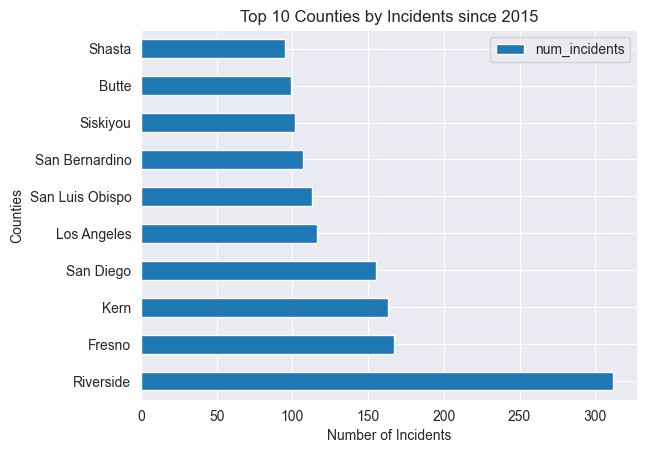

In [104]:
plt.figure(figsize=(12, 6))
top_counties_amount.head(10).plot(kind='barh', x='incident_county', y='num_incidents')
plt.title('Top 10 Counties by Incidents since 2015')
plt.xlabel('Number of Incidents')
plt.ylabel('Counties')
plt.show()

The output above demonstrates the top five counties with the highest number of incidents. At the time of analysis, Riverside county has the greatest number of incidents in the dataset at a value of 312, followed by Fresno with 163 incidents, then by Kern County, San Diego, and Los Angeles. The list of largest counties by total area in descending order is San Bernardino , Inyo, Kern, Riverside, and Siskiyou Counties. This means that a county's size does not necessarily dictate it's number of incidents. This is likely because more urban areas have a greater number of smaller incidents, while areas with more wilderness acres have fewer, but larger fires.

<Figure size 1200x600 with 0 Axes>

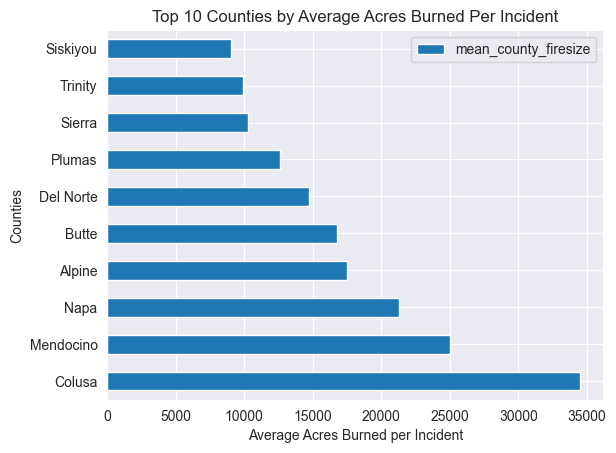

In [105]:
plt.figure(figsize=(12, 6))
top_counties_mean.head(10).plot(kind='barh', x='incident_county', y='mean_county_firesize')
plt.title('Top 10 Counties by Average Acres Burned Per Incident')
plt.xlabel('Average Acres Burned per Incident')
plt.ylabel('Counties')
plt.show()

As just directly mentioned, areas with more wilderness acres have fewer, but larger fires. The output block above shows this directly as it displays the average acres burned per incident within the top counties for this statistic. None of the counties on either of the last lists (top counties by amount and top counties by size) sit anywhere in the top 5. This shows that while these counties may not have as many incidents as the other counties, but incidents are drastically larger.

<Figure size 1200x600 with 0 Axes>

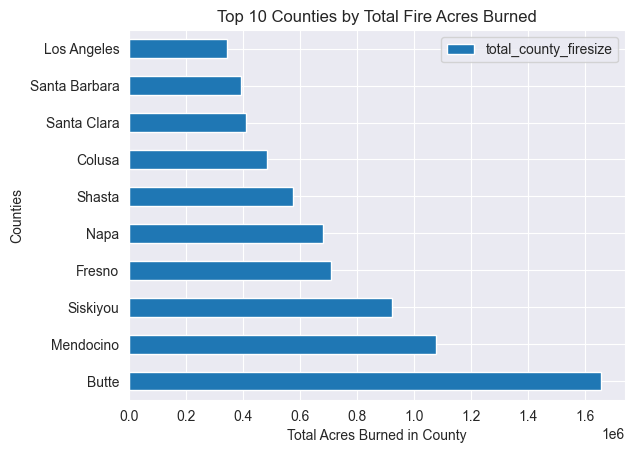

In [106]:
plt.figure(figsize=(12, 6))
top_counties_acres.head(10).plot(kind='barh', x='incident_county', y='total_county_firesize')
plt.title('Top 10 Counties by Total Fire Acres Burned')
plt.xlabel('Total Acres Burned in County')
plt.ylabel('Counties')
plt.show()

This last output shows us the total acres burned across the time range of the data set. At the time of analysis, Butte County is sitting on top with 1,658,041 acres burned in wildfires since the beginning of 2015 and Mendocino County is second with 1,076,400 acres.

To end of Part A where we dove deeper into the elements of CAL FIRE's database, we can summarize our findings with a collection of four graphs as listed below for a quick visual summary of the data quirks we have already found.

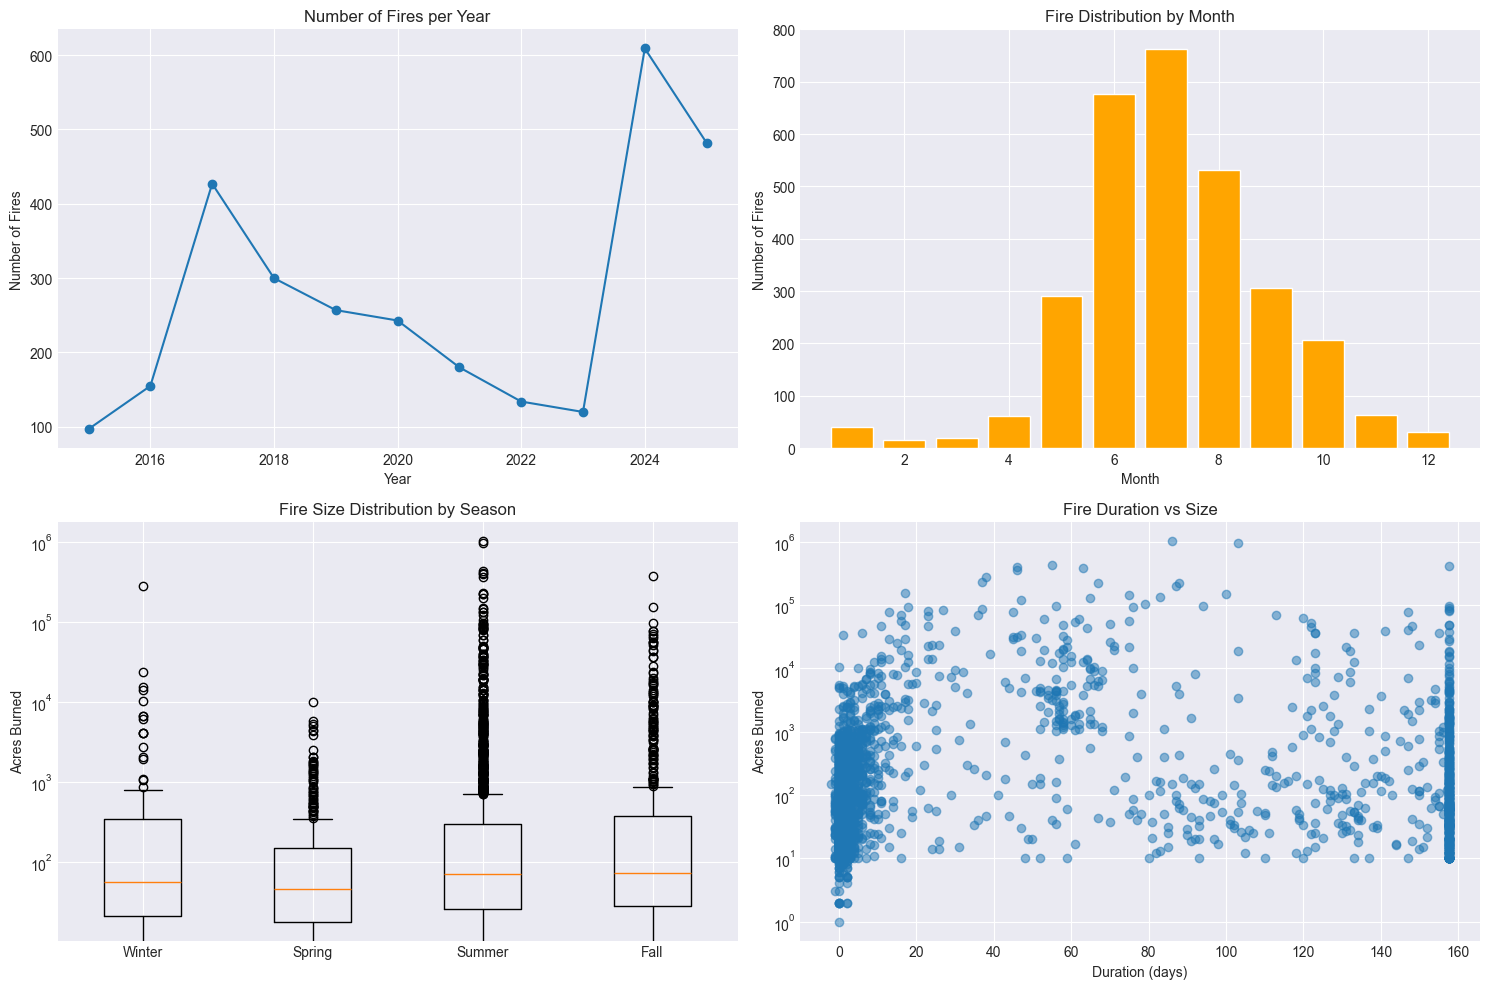

In [123]:
# Set style
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Yearly trend
yearly_stats = df_subset.groupby('incident_year').agg({
    'incident_id': 'count',
    'incident_acres_burned': 'sum'
}).reset_index()

axes[0, 0].plot(yearly_stats['incident_year'], yearly_stats['incident_id'], marker='o')
axes[0, 0].set_title('Number of Fires per Year')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Fires')

# Monthly distribution
monthly_fires = df_subset['incident_month'].value_counts().sort_index()
axes[0, 1].bar(monthly_fires.index, monthly_fires.values, color='orange')
axes[0, 1].set_title('Fire Distribution by Month')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Number of Fires')

# Fire size by season
axes[1, 0].boxplot([df_subset[df_subset['incident_season'] == s]['incident_acres_burned']
                     for s in ['Winter', 'Spring', 'Summer', 'Fall']],
                    tick_labels=['Winter', 'Spring', 'Summer', 'Fall'])
axes[1, 0].set_title('Fire Size Distribution by Season')
axes[1, 0].set_ylabel('Acres Burned')
axes[1, 0].set_yscale('log')

# Duration vs Acres correlation
axes[1, 1].scatter(df_subset['duration_days'], df_subset['incident_acres_burned'], alpha=0.5)
axes[1, 1].set_xlabel('Duration (days)')
axes[1, 1].set_ylabel('Acres Burned')
axes[1, 1].set_title('Fire Duration vs Size')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()

## Part B. Feature Engineering of Precipitation Data

Now we can move on to feature engineering for monthly precipitation grouped by counties. These elements may provide some deep insights to our analysis, so it is important that we extract as much information from the data as possible.

In [108]:
precip_df.head()

,Unnamed: 0,precip_date,precip_inches,precip_month,precip_year,county
0,0,2014-01-01,0.11,1,2014,Alameda
1,1,2014-02-01,3.94,2,2014,Alameda
2,2,2014-03-01,5.96,3,2014,Alameda
3,3,2014-04-01,7.32,4,2014,Alameda
4,4,2014-05-01,7.34,5,2014,Alameda


We can extract some interesting information from the limited information provided by the dataset. For example, we can use feature engineering in order to

In [109]:
precip_subset = precip_df.copy()
precip_subset = precip_subset.sort_values(['county','precip_year','precip_month'])
precip_subset['precip_lag1'] = precip_subset.groupby('county')['precip_inches'].shift(1)
precip_subset['precip_lag2'] = precip_subset.groupby('county')['precip_inches'].shift(2)
precip_subset['precip_lag3'] = precip_subset.groupby('county')['precip_inches'].shift(3)

precip_subset['precip_3mth_avg'] = precip_subset.groupby('county')['precip_inches'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)
precip_subset['precip_6mth_avg'] = precip_subset.groupby('county')['precip_inches'].rolling(6, min_periods=1).mean().reset_index(0, drop=True)
precip_subset['precip_12mth_avg'] = precip_subset.groupby('county')['precip_inches'].rolling(12, min_periods=1).mean().reset_index(0, drop=True)

precip_subset['precip_3mth_sum'] = precip_subset.groupby('county')['precip_inches'].rolling(3, min_periods=1).sum().reset_index(0, drop=True)
precip_subset['precip_6mth_sum'] = precip_subset.groupby('county')['precip_inches'].rolling(6, min_periods=1).sum().reset_index(0, drop=True)
precip_subset['precip_12mth_sum'] = precip_subset.groupby('county')['precip_inches'].rolling(12, min_periods=1).sum().reset_index(0, drop=True)


In [110]:
precip_subset[precip_subset['precip_year'] == 2025]

,Unnamed: 0,precip_date,precip_inches,precip_month,precip_year,county,precip_lag1,precip_lag2,precip_lag3,precip_3mth_avg,precip_6mth_avg,precip_12mth_avg,precip_3mth_sum,precip_6mth_sum,precip_12mth_sum
132,132,2025-01-01,0.25,1,2025,Alameda,22.25,18.14,15.91,13.546667,14.710000,14.524167,40.64,88.26,174.29
133,133,2025-02-01,4.57,2,2025,Alameda,0.25,22.25,18.14,9.023333,12.830000,14.071667,27.07,76.98,168.86
134,134,2025-03-01,6.88,3,2025,Alameda,4.57,0.25,22.25,3.900000,11.333333,13.520833,11.70,68.00,162.25
135,135,2025-04-01,7.26,4,2025,Alameda,6.88,4.57,0.25,6.236667,9.891667,12.874167,18.71,59.35,154.49
136,136,2025-05-01,7.42,5,2025,Alameda,7.26,6.88,4.57,7.186667,8.105000,12.172500,21.56,48.63,146.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8057,8057,2025-03-01,17.34,3,2025,Yuba,12.07,1.51,43.90,10.306667,22.876667,23.878333,30.92,137.26,286.54
8058,8058,2025-04-01,19.06,4,2025,Yuba,17.34,12.07,1.51,16.156667,21.740000,23.520833,48.47,130.44,282.25
8059,8059,2025-05-01,19.71,5,2025,Yuba,19.06,17.34,12.07,18.703333,18.931667,23.075000,56.11,113.59,276.90
8060,8060,2025-06-01,19.72,6,2025,Yuba,19.71,19.06,17.34,19.496667,14.901667,22.630000,58.49,89.41,271.56


## Part C. Merging Precipitation to CAL FIRE
Knowing precipitation data for our machine learning predictive models allows us to combine the metrics of wildfires with rainfall. This can give us a deep insight into how "wet years" coincide with higher risks of wildfires. In order for us to construct a model, we can left merge these dataframes together on their counties and months.

In [120]:
df_subset.head()

precip_subset = precip_subset.loc[:, ~precip_subset.columns.str.contains('^Unnamed')]
df_subset = df_subset.loc[:, ~df_subset.columns.str.contains('^Unnamed')]
precip_subset.head()
df_subset.head()

,incident_name,incident_date_created,incident_administrative_unit,incident_county,incident_location,incident_acres_burned,incident_containment,incident_cooperating_agencies,incident_longitude,incident_latitude,...,is_active,calfire_incident,duration,duration_days,incident_latitude_clean,incident_longitude_clean,incident_year,incident_month,is_fire_season,incident_season
0,Bridge Fire,2017-10-31 11:22:00+00:00,Shasta-Trinity National Forest,Shasta,"I-5 and Turntable Bay, 7 miles NE of Shasta Lake",37.0,100.0,Shasta-Trinity National Forest,-122.309000,40.774000,...,N,False,70 days 02:24:00,70.0,40.774000,-122.309000,2017,10,1,Fall
212,Stephens Fire,2015-02-24 12:15:00+00:00,Shasta-Trinity National Forest,Siskiyou,"Approx. 18 miles northeast of McCloud, just so...",200.0,100.0,Shasta-Trinity National Forest,-121.851000,41.485000,...,N,False,5 days 20:45:00,5.0,41.485000,-121.851000,2015,2,0,Winter
220,Otay Fire,2015-06-26 16:06:00+00:00,CAL FIRE San Diego Unit / Chula Vista Fire Dep...,San Diego,off Otay Lakes Road and Woods Drive in Chula V...,80.0,100.0,CAL FIRE San Diego Unit / Chula Vista Fire Dep...,-116.945439,32.644916,...,N,True,0 days 06:09:00,0.0,32.644916,-116.945439,2015,6,1,Summer
221,Ward Fire,2015-04-13 05:30:00+00:00,**This was NOT a CAL FIRE Incident. Click this...,Plumas,East of Taylorsville,137.0,100.0,**This was NOT a CAL FIRE Incident. Click this...,-120.701667,40.050833,...,N,True,5 days 18:20:00,5.0,40.050833,-120.701667,2015,4,0,Spring
222,Highway Fire,2015-04-18 18:12:00+00:00,CAL FIRE/Riverside County Fire,Riverside,at Hwy 71/Hwy 91 near the Prado Basin,1049.0,100.0,"CAL FIRE/Riverside County Fire, City of Corona...",-117.642759,33.884313,...,N,True,5 days 13:18:00,5.0,33.884313,-117.642759,2015,4,0,Spring
